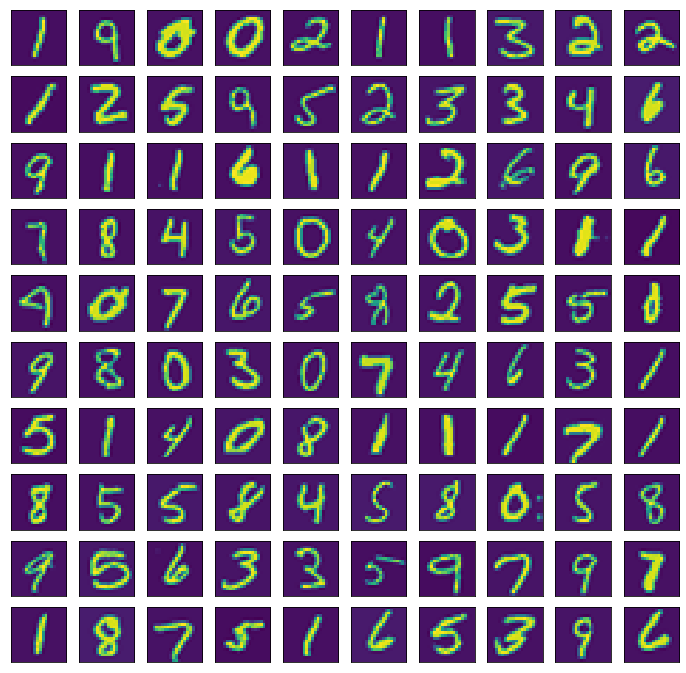

In [29]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

X = loadmat('ex4data1.mat')['X']
y = loadmat('ex4data1.mat')['y']

fig, axi = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(12, 12))
img_idx = np.random.choice(X.shape[0], 100)

for r in range(10):
    for c in range(10):
        axi[r, c].matshow(X[img_idx[10*r+c]].reshape((20, 20)).T)
        plt.xticks([])
        plt.yticks([])

**接下来将通过使用工具库来计算使代价函数取（局部或全局）最小值（因为为非凸函数）的权重。首先要求出目标函数，即cost函数，然后通过反向传播求梯
度，这中间需要用梯度检测来检测梯度是否正确。然后用工具库求解theta，注意要使用随机初始化而不是用全0，因为全0得出来的特征只有一个，换句话说，
你训练出来的模型效果不好，因为没有包含足够的有效特征（个人理解）。**
***
输出层的δ是差值呢，还是要乘上sigmoid_gradient(z)呢，看都有用的，我自己推导的是前者，但是它的效果比后者差o_O

              precision    recall  f1-score   support

           1       0.92      0.98      0.95       500
           2       0.91      0.88      0.89       500
           3       0.91      0.89      0.90       500
           4       0.88      0.90      0.89       500
           5       0.87      0.88      0.87       500
           6       0.94      0.95      0.94       500
           7       0.94      0.92      0.93       500
           8       0.90      0.81      0.85       500
           9       0.90      0.90      0.90       500
          10       0.93      0.98      0.96       500

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



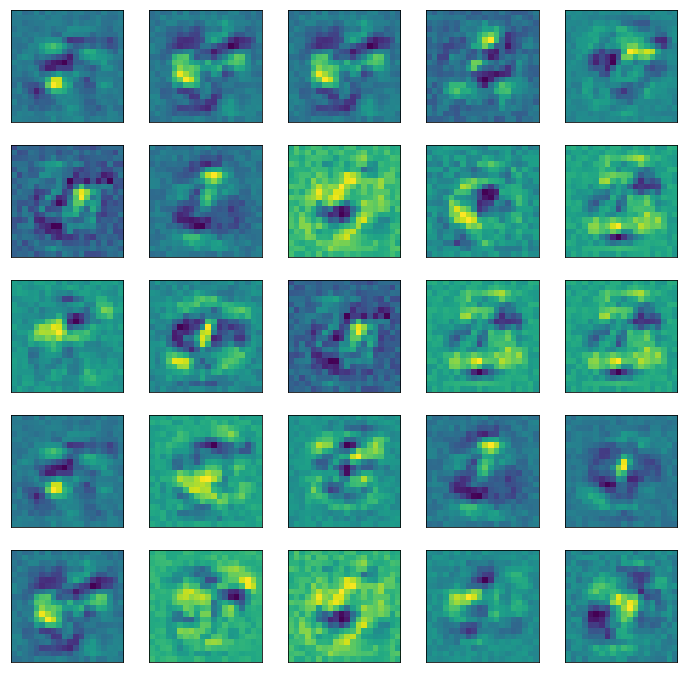

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import classification_report

X = loadmat('ex4data1.mat')['X']
y = loadmat('ex4data1.mat')['y']
Y = y.copy()
theta1 = loadmat('ex4weights.mat')['Theta1']
theta2 = loadmat('ex4weights.mat')['Theta2']
y = np.array([[1 if y[j, 0] == i else 0 for i in range(1, 11)] for j in range(y.shape[0])])
lam = 1
epsilon = 1e-2
input_size = X.shape[1]
output_size = y.shape[1]
hidden_size = theta1.shape[0]
theta = (np.random.random(size=(input_size+1)*hidden_size+output_size*(hidden_size+1)) - 0.5) * 0.24

def sigmoid(x):
    return 1/(1+np.exp(-x))

def f_pro(X, theta1, theta2):
    X = np.matrix(X)
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    a1 = np.insert(X, 0, values=1, axis=1)
    z2 = a1@theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=1, axis=1)
    z3 = a2@theta2.T
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

def cost(theta, input_size, hidden_size, ouput_size, X, y, lam):
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta)
    theta1 = theta[0, :hidden_size*(input_size+1)].reshape(hidden_size, input_size+1)
    theta2 = theta[0, hidden_size*(input_size+1):].reshape(output_size, hidden_size+1)
    
    h = f_pro(X, theta1, theta2)[4]
    A = np.multiply(-y, np.log(h))
    B = np.multiply(-(1-y), np.log(1-h))
    first = np.sum(A+B)/X.shape[0]
    second = lam/(X.shape[0]*2)*(np.sum(np.power(theta1[:, 1:], 2))+np.sum(np.power(theta2[:, 1:], 2)))
    return first+second

def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

def back_pro(theta, input_size, hidden_size, ouput_size, X, y, lam):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    theta1 = theta[0, :hidden_size*(input_size+1)].reshape(hidden_size, input_size+1)
    theta2 = theta[0, hidden_size*(input_size+1):].reshape(output_size, hidden_size+1)
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)
    
    a1, z2, a2, z3, h = f_pro(X, theta1, theta2)
    for i in range(X.shape[0]):
        a1t = a1[i, :]
        z2t = z2[i, :]
        a2t = a2[i, :]
        z3t = z3[i, :]
        ht = h[i, :]
        yt = y[i, :]
        z2t = np.insert(z2t, 0, values=1, axis=1)
        
        d3t = np.multiply(ht - yt, sigmoid_gradient(z3t))
        d2t = np.delete(np.multiply(d3t@theta2, sigmoid_gradient(z2t)), 0, axis=1)
        
        delta1 = delta1 + d2t.T@a1t
        delta2 = delta2 + d3t.T@a2t
    
    delta1 = delta1/X.shape[0]
    delta2 = delta2/X.shape[0]
    
    delta1[:, 1:] = delta1[:, 1:]+(lam/X.shape[0])*theta1[:, 1:]
    delta2[:, 1:] = delta2[:, 1:]+(lam/X.shape[0])*theta2[:, 1:]
    
    return np.concatenate((np.ravel(delta1), np.ravel(delta2)))

def gradient_check(theta, input_size, hidden_size, ouput_size, X, y, lam, epsilon):
    grad = np.zeros(theta.shape)
    for i in range(theta.shape[1]):
        theta_buff1 = theta.copy()
        theta_buff2 = theta.copy()
        theta_buff1[0, i] = theta[0,i]+epsilon
        theta_buff2[0, i] = theta[0,i]-epsilon
        grad[i] = (cost(theta_buff1, input_size, hidden_size, ouput_size, X, y, lam)-cost(theta_buff2, input_size, hidden_size, ouput_size, X, y, lam))/(2*epsilon)
    return grad

result = np.matrix(minimize(fun=cost, x0=(theta), args=(input_size, hidden_size, output_size, X, y, lam), method='TNC', jac=back_pro, options={'maxiter': 250}).x)

theta1 = result[0, :hidden_size*(input_size+1)].reshape(hidden_size, input_size+1)
theta2 = result[0, hidden_size*(input_size+1):].reshape(output_size, hidden_size+1)

a1, z2, a2, z3, h = f_pro(X, theta1, theta2)
h = np.argmax(h, axis=1)+1
print(classification_report(Y, h))

thetafinal = theta1[:, 1:]
fig, axi = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(12, 12))
img_idx = np.random.choice(thetafinal.shape[0], 25)

for r in range(5):
    for c in range(5):
        axi[r, c].matshow(thetafinal[img_idx[5*r+c]].reshape((20, 20)).T)
        plt.xticks([])
        plt.yticks([])

In [69]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import classification_report

X = loadmat('ex4data1.mat')['X']
y = loadmat('ex4data1.mat')['y']
Y = y.copy()
theta1 = loadmat('ex4weights.mat')['Theta1']
theta2 = loadmat('ex4weights.mat')['Theta2']
y = np.array([[1 if y[j, 0] == i else 0 for i in range(1, 11)] for j in range(y.shape[0])])
lam = 1
epsilon = 1e-2
input_size = X.shape[1]
output_size = y.shape[1]
hidden_size = theta1.shape[0]
theta = (np.random.random(size=(input_size+1)*hidden_size+output_size*(hidden_size+1)) - 0.5) * 0.24

def sigmoid(x):
    return 1/(1+np.exp(-x))

def f_pro(X, theta1, theta2):
    X = np.matrix(X)
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    a1 = np.insert(X, 0, values=1, axis=1)
    z2 = a1@theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=1, axis=1)
    z3 = a2@theta2.T
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

def cost(theta, input_size, hidden_size, ouput_size, X, y, lam):
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta)
    theta1 = theta[0, :hidden_size*(input_size+1)].reshape(hidden_size, input_size+1)
    theta2 = theta[0, hidden_size*(input_size+1):].reshape(output_size, hidden_size+1)
    
    h = f_pro(X, theta1, theta2)[4]
    A = np.multiply(-y, np.log(h))
    B = np.multiply(-(1-y), np.log(1-h))
    first = np.sum(A+B)/X.shape[0]
    second = lam/(X.shape[0]*2)*(np.sum(np.power(theta1, 2))+np.sum(np.power(theta2, 2)))
    return first+second

def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

def back_pro(theta, input_size, hidden_size, ouput_size, X, y, lam):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    theta1 = theta[0, :hidden_size*(input_size+1)].reshape(hidden_size, input_size+1)
    theta2 = theta[0, hidden_size*(input_size+1):].reshape(output_size, hidden_size+1)
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)
    
    a1, z2, a2, z3, h = f_pro(X, theta1, theta2)
    for i in range(X.shape[0]):
        a1t = a1[i, :]
        z2t = z2[i, :]
        a2t = a2[i, :]
        z3t = z3[i, :]
        ht = h[i, :]
        yt = y[i, :]
        z2t = np.insert(z2t, 0, values=1, axis=1)
        
        d3t = ht - yt
        d2t = np.delete(np.multiply(d3t@theta2, sigmoid_gradient(z2t)), 0, axis=1)
        
        delta1 = delta1 + d2t.T@a1t
        delta2 = delta2 + d3t.T@a2t
    
    delta1 = delta1/X.shape[0]
    delta2 = delta2/X.shape[0]
    
    delta1[:, 1:] = delta1[:, 1:]+(lam/X.shape[0])*theta1[:, 1:]
    delta2[:, 1:] = delta2[:, 1:]+(lam/X.shape[0])*theta2[:, 1:]
    
    return np.concatenate((np.ravel(delta1), np.ravel(delta2)))

def gradient_check(theta, input_size, hidden_size, ouput_size, X, y, lam, epsilon):
    grad = np.zeros(theta.shape)
    for i in range(theta.shape[1]):
        theta_buff1 = theta.copy()
        theta_buff2 = theta.copy()
        theta_buff1[0, i] = theta[0,i]+epsilon
        theta_buff2[0, i] = theta[0,i]-epsilon
        grad[i] = (cost(theta_buff1, input_size, hidden_size, ouput_size, X, y, lam)-cost(theta_buff2, input_size, hidden_size, ouput_size, X, y, lam))/(2*epsilon)
    return grad

result = np.matrix(minimize(fun=cost, x0=(theta), args=(input_size, hidden_size, output_size, X, y, lam), method='TNC', jac=back_pro, options={'maxiter': 250}).x)

theta1 = result[0, :hidden_size*(input_size+1)].reshape(hidden_size, input_size+1)
theta2 = result[0, hidden_size*(input_size+1):].reshape(output_size, hidden_size+1)

a1, z2, a2, z3, h = f_pro(X, theta1, theta2)
h = np.argmax(h, axis=1)+1
print(classification_report(Y, h))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       0.99      0.99      0.99       500
           3       0.99      0.98      0.99       500
           4       0.99      0.99      0.99       500
           5       1.00      0.99      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      0.99      0.99       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       0.99      1.00      0.99       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

